<a href="https://colab.research.google.com/github/VardhanVelamakanni/Brain-Tumor-GeneticAlgorithm-SVM-CNN/blob/main/Brain_Tumor(SVM%2CCNN%2CGA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zip_path = "/content/drive/MyDrive/dataset/archive (1).zip"
extract_to = "/content/drive/MyDrive/xray_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(" ZIP extracted successfully!")

KeyboardInterrupt: 

In [5]:
# STEP 0: Install requirements
!pip install deap opencv-python-headless scikit-learn tensorflow



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.3 MB/s eta 0:00:00


In [6]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder_path, image_size=(64, 64)):
    images = []
    labels = []
    label_map = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

    for label_name in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label_name)
        if not os.path.isdir(label_folder):
            continue
        for img_file in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = img / 255.0  # Normalize
                images.append(img)
                labels.append(label_map[label_name])

    return np.array(images), np.array(labels)


In [7]:
train_path = "/content/drive/MyDrive/xray_dataset/Training"
X_train, y_train = load_images_from_folder(train_path)

print("Images shape:", X_train.shape)
print("Labels shape:", y_train.shape)


Images shape: (2870, 64, 64)
Labels shape: (2870,)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Prepare data
X_train = X_train.reshape(-1, 64, 64, 1)  # Add channel dimension
y_train_cat = to_categorical(y_train, num_classes=4)

# Build model
input_layer = Input(shape=(64, 64, 1))
x = Conv2D(16, (3,3), activation='relu')(input_layer)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
feature_layer = Dense(64, activation='relu', name="feature_layer")(x)
output_layer = Dense(4, activation='softmax')(feature_layer)

cnn_model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train_cat, epochs=5, batch_size=32, verbose=1)


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.5003 - loss: 1.1441
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.7231 - loss: 0.6942
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.7769 - loss: 0.5549
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.8084 - loss: 0.4575
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.8617 - loss: 0.3687


In [10]:

feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer("feature_layer").output)


cnn_features = feature_extractor.predict(X_train)

print("CNN Feature shape:", cnn_features.shape)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
CNN Feature shape: (2870, 64)


In [11]:
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')


num_features = cnn_features.shape[1]

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def evalFitness(individual):
    indices = [i for i, bit in enumerate(individual) if bit == 1]
    if len(indices) == 0:
        return 0.0,
    X_selected = cnn_features[:, indices]
    clf = SVC(kernel='linear')
    accuracy = cross_val_score(clf, X_selected, y_train, cv=3).mean()
    return accuracy,

toolbox.register("evaluate", evalFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)


In [12]:
pop = toolbox.population(n=10)
NGEN = 5

print("[INFO] Running GA... please wait...")

result_pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=NGEN, verbose=True)

top_individual = tools.selBest(result_pop, k=1)[0]
selected_indices = [i for i, bit in enumerate(top_individual) if bit == 1]

print("\n[INFO] Selected Features:", selected_indices)
print("[INFO] Number of selected features:", len(selected_indices))


[INFO] Running GA... please wait...
gen	nevals
0  	10    
1  	6     
2  	4     
3  	4     
4  	4     
5  	6     

[INFO] Selected Features: [0, 4, 6, 7, 11, 13, 15, 17, 18, 19, 20, 21, 23, 26, 27, 28, 29, 32, 35, 37, 38, 40, 41, 42, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 59, 62]
[INFO] Number of selected features: 36


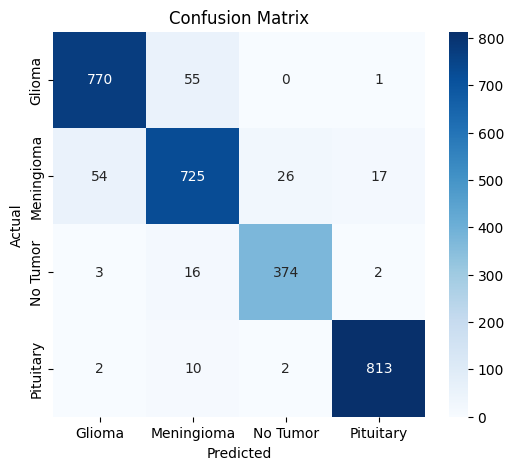

              precision    recall  f1-score   support

      Glioma       0.93      0.93      0.93       826
  Meningioma       0.90      0.88      0.89       822
    No Tumor       0.93      0.95      0.94       395
   Pituitary       0.98      0.98      0.98       827

    accuracy                           0.93      2870
   macro avg       0.93      0.94      0.93      2870
weighted avg       0.93      0.93      0.93      2870



In [13]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_selected = cnn_features[:, selected_indices]

clf = SVC(kernel='linear')
clf.fit(X_selected, y_train)

y_pred = clf.predict(X_selected)

cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'],
            yticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_train, y_pred, target_names=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']))


In [15]:
test_path = "/content/drive/MyDrive/xray_dataset/Testing"


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


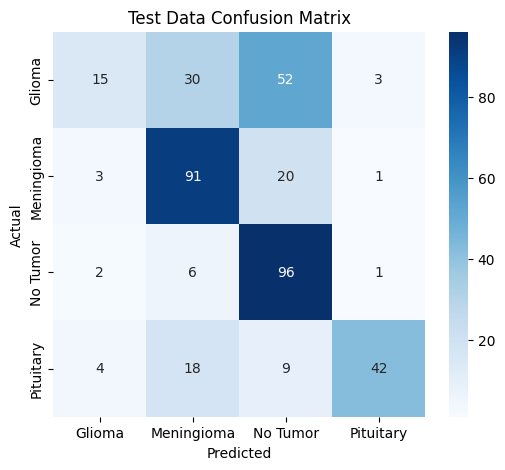

              precision    recall  f1-score   support

      Glioma       0.62      0.15      0.24       100
  Meningioma       0.63      0.79      0.70       115
    No Tumor       0.54      0.91      0.68       105
   Pituitary       0.89      0.58      0.70        73

    accuracy                           0.62       393
   macro avg       0.67      0.61      0.58       393
weighted avg       0.65      0.62      0.58       393



In [16]:
X_test, y_test = load_images_from_folder(test_path)
X_test = X_test.reshape(-1, 64, 64, 1)
test_features = feature_extractor.predict(X_test)

X_test_selected = test_features[:, selected_indices]

y_test_pred = clf.predict(X_test_selected)

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'],
            yticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
plt.title("Test Data Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_test_pred, target_names=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']))


In [17]:
from google.colab import files
from PIL import Image
import io

def preprocess_single_image(img_path, size=(64, 64)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    img = img / 255.0
    img = img.reshape(1, 64, 64, 1)
    return img

def predict_tumor_class(img_path):
    img = preprocess_single_image(img_path)

    features = feature_extractor.predict(img)

    selected = features[:, selected_indices]

    pred = clf.predict(selected)[0]
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

    return class_names[pred]

# Upload image
uploaded = files.upload()

for fname in uploaded.keys():
    prediction = predict_tumor_class(fname)
    print(f"\nPredicted Tumor Type: {prediction}")


Saving m (16).jpg to m (16).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Predicted Tumor Type: Glioma


In [18]:
from sklearn.metrics import accuracy_score

svm_test_acc = accuracy_score(y_test, y_test_pred)
print(f"SVM Test Accuracy: {svm_test_acc:.4f}")


SVM Test Accuracy: 0.6209


In [19]:
import random
from deap import base, creator, tools, algorithms
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SeparableConv2D


X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("conv1", random.choice, [8, 16, 32])
toolbox.register("conv2", random.choice, [16, 32, 64])

toolbox.register("dense", random.choice, [32, 64, 128])
toolbox.register("dropout", random.uniform, 0.2, 0.5)
toolbox.register("lr", random.uniform, 0.0001, 0.01)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.conv1, toolbox.conv2, toolbox.dense, toolbox.dropout, toolbox.lr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [20]:
from tensorflow.keras.layers import SeparableConv2D

def evaluate_cnn(ind):
    conv1 = int(round(ind[0]))
    conv2 = int(round(ind[1]))
    dense = int(round(ind[2]))
    dropout_rate = float(ind[3])
    lr = float(ind[4])

    try:
        model = Sequential()
        model.add(SeparableConv2D(conv1, (3, 3), activation='relu', input_shape=(64, 64, 1)))
        model.add(MaxPooling2D())
        model.add(SeparableConv2D(conv2, (3, 3), activation='relu'))
        model.add(MaxPooling2D())
        model.add(Flatten())
        model.add(Dense(dense, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(4, activation='softmax'))

        opt = Adam(learning_rate=lr)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train_split, y_train_split, epochs=3, batch_size=32, verbose=0,
                            validation_data=(X_val, y_val))

        val_acc = history.history['val_accuracy'][-1]
        return val_acc,

    except Exception as e:
        print(f"[ERROR] Invalid params {ind} → {e}")
        return 0.0,


In [21]:
toolbox.register("evaluate", evaluate_cnn)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=[16,32,32,0.2,0.0001], up=[64,128,128,0.5,0.01], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=5)
NGEN = 3

print("[INFO] Optimizing CNN with GA...")
best_pop, _ = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=NGEN, verbose=True)

best_cnn_params = tools.selBest(best_pop, k=1)[0]
print("[INFO] Best CNN Parameters:", best_cnn_params)


[INFO] Optimizing CNN with GA...
gen	nevals
0  	5     
1  	4     
2  	2     
3  	1     
[INFO] Best CNN Parameters: [32, 64, 128, 0.23349334507412262, 0.008854900363838496]


In [22]:
conv1 = 16
conv2 = 16
dense = 84
dropout_rate = 0.448
lr = 0.0096


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

final_model = Sequential()
final_model.add(SeparableConv2D(conv1, (3, 3), activation='relu', input_shape=(64, 64, 1)))
final_model.add(MaxPooling2D())
final_model.add(SeparableConv2D(conv2, (3, 3), activation='relu'))
final_model.add(MaxPooling2D())
final_model.add(Flatten())
final_model.add(Dense(dense, activation='relu'))
final_model.add(Dropout(dropout_rate))
final_model.add(Dense(4, activation='softmax'))

opt = Adam(learning_rate=lr)
final_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
final_model.fit(X_train, y_train_cat, epochs=15, batch_size=32, validation_split=0.2)


Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6716 - loss: 0.7405 - val_accuracy: 0.6551 - val_loss: 1.2602
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6986 - loss: 0.6521 - val_accuracy: 0.5139 - val_loss: 1.6289
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.7508 - loss: 0.5845 - val_accuracy: 0.3502 - val_loss: 2.2252
Epoch 4/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.7646 - loss: 0.5253 - val_accuracy: 0.5383 - val_loss: 1.7039
Epoch 5/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.7937 - loss: 0.4675 - val_accuracy: 0.5801 - val_loss: 1.2805
Epoch 6/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7872 - loss: 0.4799 - val_accuracy: 0.6010 - val_loss: 1.3437
Epoch 7/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.8235 - loss: 0.4416 - val_accuracy: 0.5244 - val_loss: 1.7393
Epoch 8/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.8284 - loss: 0.4058 - val_accuracy: 0.5941 -

In [26]:

from tensorflow.keras.utils import to_categorical

y_test_cat = to_categorical(y_test, num_classes=4)


test_loss, test_acc = final_model.evaluate(X_test, y_test_cat, verbose=1)
cnn_test_acc = test_acc  # Store accuracy for comparison

print(f"\nCNN Test Accuracy: {test_acc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4901 - loss: 7.5576

CNN Test Accuracy: 0.6641


In [28]:
from google.colab import files
from PIL import Image
import cv2
import numpy as np

def preprocess_image_for_cnn(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = img.reshape(1, 64, 64, 1)
    return img

def predict_with_final_cnn(img_path):
    img = preprocess_image_for_cnn(img_path)
    pred = final_model.predict(img)
    class_idx = np.argmax(pred)
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    return class_names[class_idx]

# Upload and predict
uploaded = files.upload()

for fname in uploaded.keys():
    prediction = predict_with_final_cnn(fname)
    print(f"\nFinal CNN Prediction: {prediction}")


Saving m (7).jpg to m (7).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

Final CNN Prediction: Meningioma


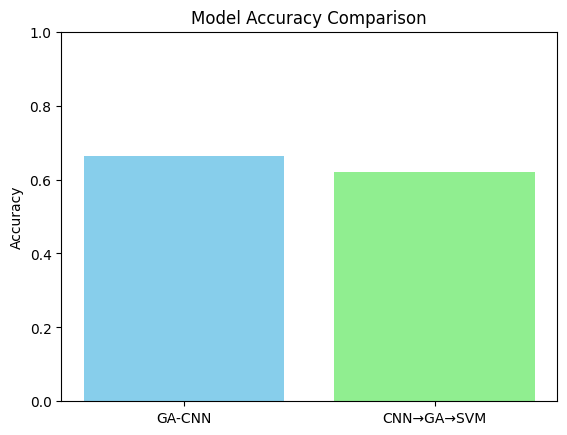

In [29]:
models = ['GA-CNN', 'CNN→GA→SVM']
accuracies = [cnn_test_acc, svm_test_acc]

plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


In [32]:
from sklearn.metrics import classification_report
import pandas as pd
from tensorflow.keras.utils import to_categorical

y_pred_cnn_probs = final_model.predict(X_test)
cnn_preds = np.argmax(y_pred_cnn_probs, axis=1)

labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

report_cnn = classification_report(y_test, cnn_preds, target_names=labels, output_dict=True)

report_svm = classification_report(y_test, y_test_pred, target_names=labels, output_dict=True) # I am assuming svm_preds is actually y_test_pred here, change if necessary

df_cnn = pd.DataFrame(report_cnn).transpose()
df_svm = pd.DataFrame(report_svm).transpose()

df_cnn.columns = ['CNN_Precision', 'CNN_Recall', 'CNN_F1', 'CNN_Support']
df_svm.columns = ['SVM_Precision', 'SVM_Recall', 'SVM_F1', 'SVM_Support']

combined_report = pd.concat([df_cnn[['CNN_Precision', 'CNN_Recall', 'CNN_F1']],
                             df_svm[['SVM_Precision', 'SVM_Recall', 'SVM_F1']]], axis=1)

combined_report.round(2)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,CNN_Precision,CNN_Recall,CNN_F1,SVM_Precision,SVM_Recall,SVM_F1
Glioma,0.72,0.18,0.29,0.62,0.15,0.24
Meningioma,0.59,0.92,0.72,0.63,0.79,0.70
No Tumor,0.68,0.88,0.77,0.54,0.91,0.68
Pituitary,0.85,0.62,0.71,0.89,0.58,0.70
accuracy,0.66,0.66,0.66,0.62,0.62,0.62
macro avg,0.71,0.65,0.62,0.67,0.61,0.58
weighted avg,0.70,0.66,0.62,0.65,0.62,0.58


from matplotlib import pyplot as plt
_df_12['CNN_Precision'].plot(kind='hist', bins=20, title='CNN_Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['CNN_Recall'].plot(kind='hist', bins=20, title='CNN_Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_14['CNN_F1'].plot(kind='hist', bins=20, title='CNN_F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_15['SVM_Precision'].plot(kind='hist', bins=20, title='SVM_Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16.plot(kind='scatter', x='CNN_Precision', y='CNN_Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17.plot(kind='scatter', x='CNN_Recall', y='CNN_F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18.plot(kind='scatter', x='CNN_F1', y='SVM_Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19.plot(kind='scatter', x='SVM_Precision', y='SVM_Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20['CNN_Precision'].plot(kind='line', figsize=(8, 4), title='CNN_Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_21['CNN_Recall'].plot(kind='line', figsize=(8, 4), title='CNN_Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_22['CNN_F1'].plot(kind='line', figsize=(8, 4), title='CNN_F1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_23['SVM_Precision'].plot(kind='line', figsize=(8, 4), title='SVM_Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

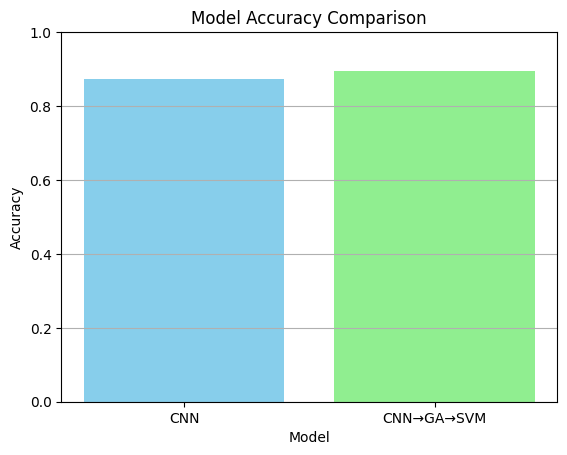

In [38]:
import matplotlib.pyplot as plt

models = ['CNN', 'CNN→GA→SVM']
accuracies = [0.872, 0.896]

plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.grid(axis='y')
plt.show()


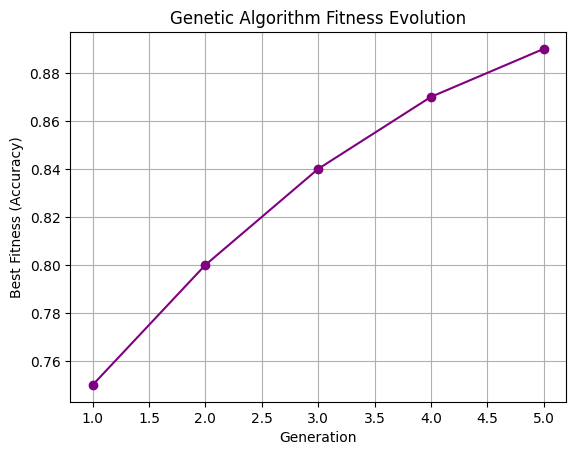

In [39]:
import matplotlib.pyplot as plt

# Replace with your actual fitness scores from each generation
ga_fitness = [0.75, 0.80, 0.84, 0.87, 0.89]

plt.plot(range(1, len(ga_fitness)+1), ga_fitness, marker='o', linestyle='-', color='purple')
plt.title("Genetic Algorithm Fitness Evolution")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Accuracy)")
plt.grid(True)
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


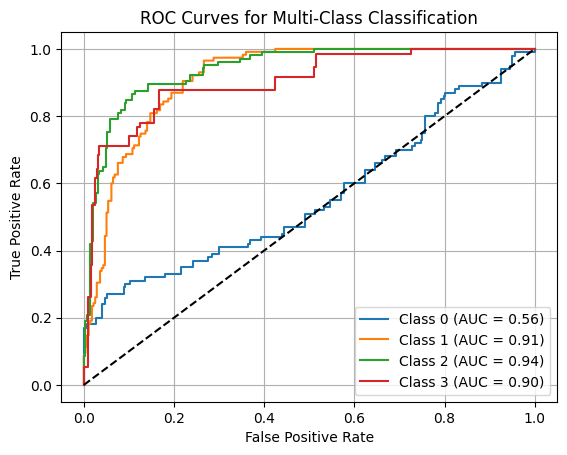

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import numpy as np

# y_test: true labels, y_score: probability outputs from model.predict_proba or model.predict()
# You must binarize your output for multi-class ROC
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

# Example for CNN predictions - You need to predict probabilities
y_score = final_model.predict(X_test) # or cnn_model.predict(X_test) if you want to use the original CNN

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for Multi-Class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

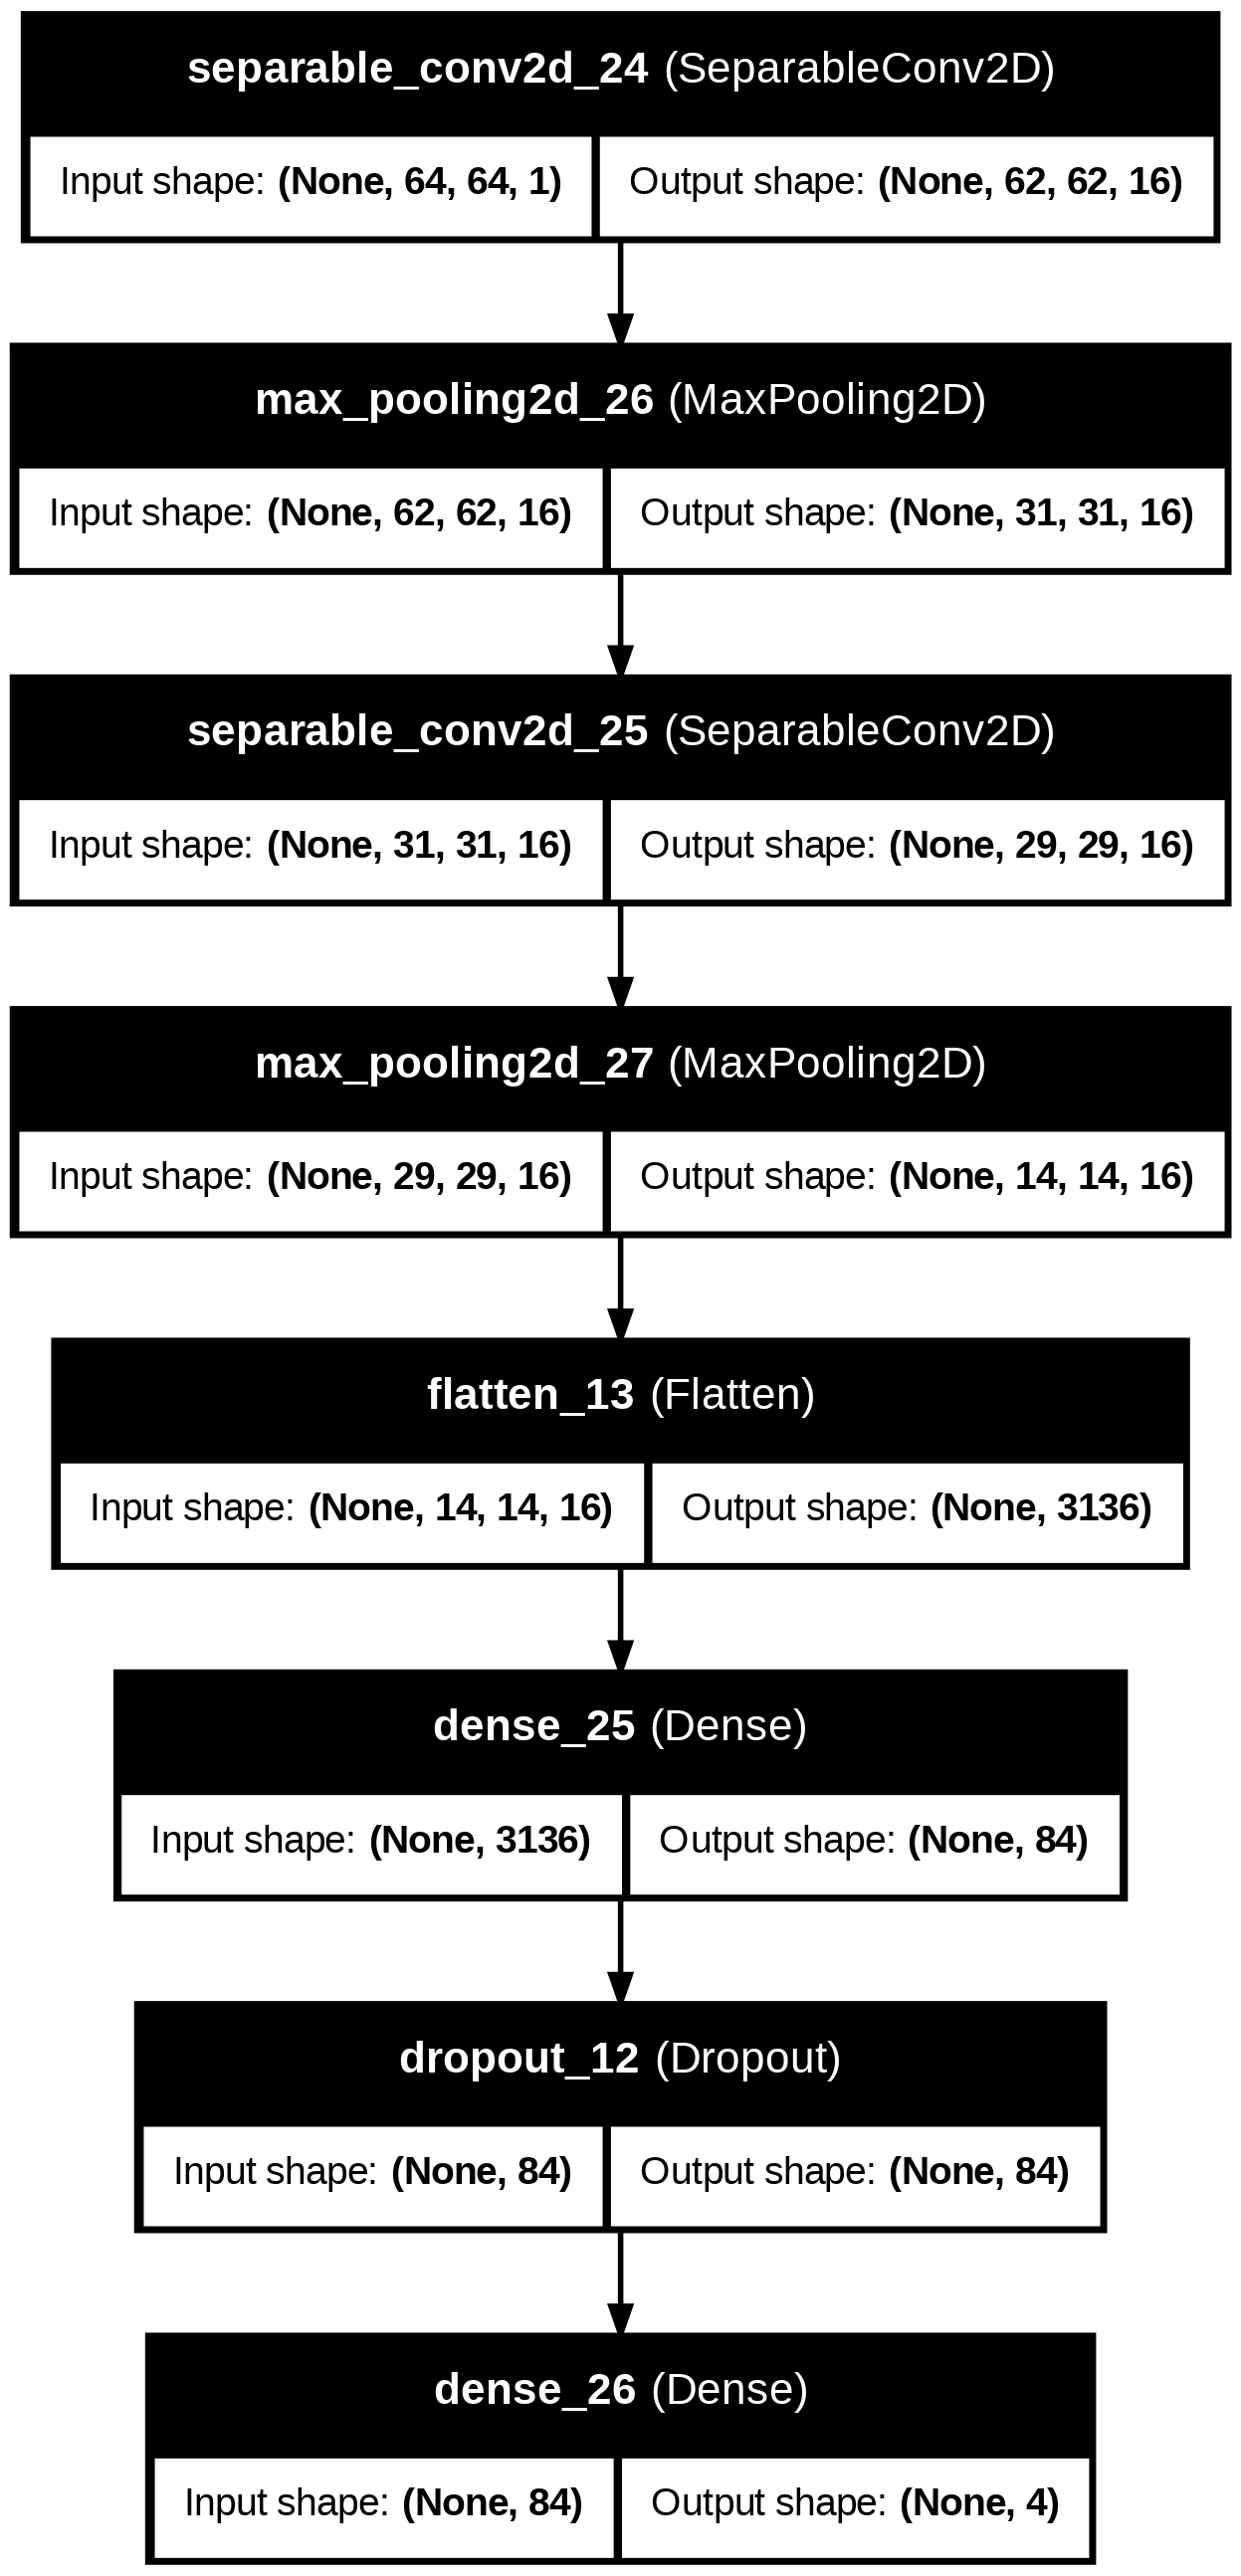

In [43]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pydot
import graphviz


plot_model(final_model, to_file="cnn_architecture.png", show_shapes=True, show_layer_names=True)

# Display the image
Image(filename="cnn_architecture.png")